# 08 Forcasting Churn

In [1]:
import json
import sqlalchemy
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint
from typing import Tuple, List, Dict

In [2]:
# Make a sql connection with sqlalchmey
conn_string = "postgresql://postgres-db/churn?user=postgres&password=password" 
engine = sqlalchemy.create_engine(
    conn_string, connect_args={'options': '-csearch_path={}'.format("socialnet7,public")}
)
conn = engine.connect()
# conn.close()

# Query with Pandas, e.g. list all tables
tables = pd.read_sql_query("SELECT * FROM information_schema.tables;", conn)
tables.head(3)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,churn,socialnet7,active_period,BASE TABLE,None,None,None,None,None,YES,NO,None
1,churn,socialnet7,event_type,BASE TABLE,None,None,None,None,None,YES,NO,None
2,churn,socialnet7,metric_name,BASE TABLE,None,None,None,None,None,YES,NO,None


In [3]:
import json 

with open("/app/fightchurn/listings/conf/socialnet7_listings.json", "r") as f: 
    conf = json.loads(f.read())
    # conf = Box(json.loads(f.read()))

chap8 = conf["chap8"]

## Dependent Data

In [4]:
import pickle

with open("/app/ch8-export.pickle", "rb") as handle:
    d = pickle.load(handle)
    
train_data = d["train_data"]
model = d["logreg_model"]
d.keys()

dict_keys(['raw_train_data', 'raw_test_data', 'train_data', 'test_data', 'logreg_model'])

In [5]:
# training data
train_data.head()

group_name,metric_group_0,metric_group_1,newfriend_pcnt_chng,unfriend_per_newfriend,days_since_newfriend,unfriend_per_month,post_per_message,newfriend_per_month,adview_per_post,like_per_post,dislike_per_month,dislike_pcnt,reply_per_message,is_churn
0,-0.549097,2.110926,-0.201102,-0.286460,-0.278495,-0.781045,-1.007845,-0.495320,-0.648489,0.529170,-0.177503,-0.443625,0.652640,False
1,0.168510,-1.119100,-0.201102,-0.286460,-0.278495,1.814266,1.937971,-0.268273,-0.881792,-0.876925,-0.177503,-0.335889,0.775205,False
2,-0.637119,1.577264,-0.201102,3.132593,-0.278495,-0.781045,-0.851206,-0.835891,-0.544171,-0.815355,-0.830230,-0.247713,0.605700,False
3,0.683287,2.265722,-0.698891,-0.286460,-0.278495,1.814266,-0.756789,-0.268273,0.936099,-1.270974,-2.135683,-1.076572,0.254015,False
4,0.176218,-1.119100,0.246908,-0.286460,-0.278495,-0.781045,0.697051,-0.041226,0.940821,1.312412,0.279693,-0.513573,0.775205,False


In [6]:
model

LogisticRegression(penalty='l1', solver='liblinear')

In [7]:
def prepare_data(grouped_data: pd.DataFrame, as_retention: bool = True) \
    -> Tuple[pd.DataFrame, pd.Series]:
    """Prepare data as X and y, with option to convert churn rate to retention rate"""
    
    X = grouped_data.drop(columns=['is_churn'])
    
    # as churn
    y = grouped_data['is_churn'].astype(int)
    
    # convert y values to retention, n.b. retention rate + churn rate = 1
    if as_retention: 
        # `is_churn = False` converted to `is_retained = True`
        y = np.subtract(1, y).rename("is_retained")
    
    return X, y
X, y = prepare_data(train_data, as_retention=True)
X.shape, y.shape, y.name

((24450, 13), (24450,), 'is_retained')

## Model Validations

### Listing 9.1 AUC

- https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, confusion_matrix,  ConfusionMatrixDisplay
)

In [9]:
def regression_auc(data: pd.DataFrame, model: LogisticRegression) -> float:
    """Compute AUC score with given churn data"""

    X, y = prepare_data(data, as_retention=True)
    
    predictions = model.predict_proba(X)
    auc_score = roc_auc_score(y, predictions[:,1])
    
    return auc_score

regression_auc(train_data, model)

0.7790057389174814

In [10]:
X, y = prepare_data(train_data, as_retention=True)

y_preds_proba = model.predict_proba(X)
# first column is "not_retained", second column is "is_retained"
y_preds = model.predict(X)
cm = confusion_matrix(y, y_preds)
pprint(cm)

array([[   33,  1350],
       [   18, 23049]])


In [11]:
y.value_counts()
# 1 as retained, 0 as not retained (churned)

1    23067
0     1383
Name: is_retained, dtype: int64

In [12]:
pd.Series(y_preds, name="is_retained_predictions").value_counts()

1    24399
0       51
Name: is_retained_predictions, dtype: int64

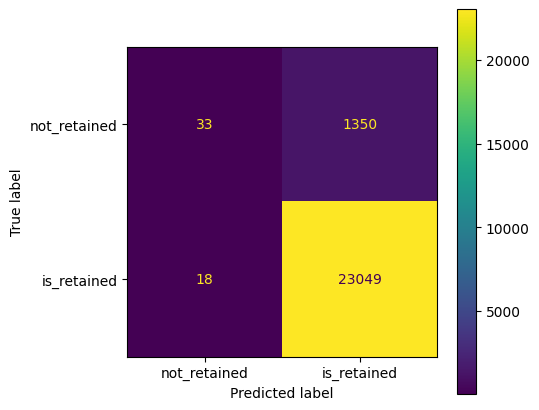

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(cm, display_labels=["not_retained", "is_retained"]).plot(ax=ax)
# ConfusionMatrixDisplay.from_predictions(y, y_preds).plot(ax=ax)
fig.show()

Notes 

- True Positive, i.e both True
  - predicted as "is_retained" and label is "is_retained" (23049)
- True Negative, i.e. both False
  - "not_retained" and "not_retained", (1350)
- False Positive, i.e. falsely classified as positive
  - predicted as "is_retained" but label is "not_retained"
- False Negative, i.e. falsely classified as negative
  - predicted as "not_retained" but label is "is_retained"
- True Positive Rate = True Positives / All Positives, also 'Sensitivity' or 'Recall'
- False Positive Rate = False Positives / All negatives, also 'Specificity'
- 

In [14]:
roc_auc_score(y, y_preds)

0.5115404179111551

In [15]:
roc_auc_score(y, y_preds_proba[:, 1])

0.7790057389174814

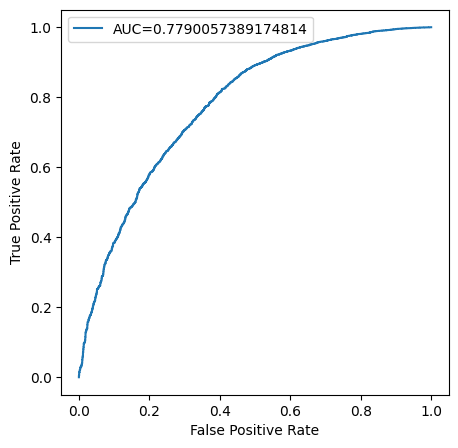

In [16]:
y_preds_proba = model.predict_proba(X)[::,1]
fpr, tpr, _ = roc_curve(y, y_preds_proba)
auc = roc_auc_score(y, y_preds_proba)

#create ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr,tpr, label=f"AUC={auc}")
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Listing 9.2 Top Decile Lift

- Lift
  - the relative increase in responses due to some treatment, relative to the baseline
  - lift = 2.0, when baseline is 1% and the increased value is 2%, (2% divided by 1%)
  - measures improvement over baseline
- Top Decile Lift
  - the ratio of churn rate in the top decile predicted to most at risk, to the overall churn rate
  - (Top decile churn rate, i.e. top 10% churn rate) divided by (Overall churn rate)
  - If in the top 10%, 2 are predicted as churn out of 5, i.e. 40% churn rate
    - Overall churn rate is 10%
    - Then Top Decile Lift is 40% / 10% = 4.0
  - Overall churn rate as baseline, because that is the churn rate if randomly guessing
  


In [18]:
def calculat_top_decile_lift(y_true: npt.NDArray, y_pred_proba: npt.NDArray) -> float:
    
    if np.unique(y_pred_proba).size < 10:
        return 1.0
    
    # overall churn rate
    overall_churn = y_true.sum() / y_true.shape[0]
    
    # top decile churn rate (top 10% at risk)
    ## sort by risk/probability to churn
    sort_by_risk = sorted(zip(y_pred_proba, y_true), key=lambda v: v[0], reverse=True)
    ## get top 10 count & index
    top10_count = round(y_true.shape[0] * .1)
    top10_churned_count = sum([v[1] for v in sort_by_risk[:top10_count]])
    ## top 10% churn rate
    top_decile_churn = top10_churned_count / top10_count
    
    # top decile lift
    lift = top_decile_churn / overall_churn
    
    return lift

def top_decile_lift(data: pd.DataFrame, model: LogisticRegression) -> float:

    X, y = prepare_data(data, as_retention=True)
    
    # first column is "not_retained", second column is "is_retained"
    # or, first is probabilty to become churned
    # or, first is risk to become churned
    predictions = model.predict_proba(X)
    
    # actual label on churn, 1 means the observation has churned
    # since the model is trained on as_retention=True, we need churn labels for lift
    y_churned = (1 - y).rename("is_churned")
    
    # top decile lift is about the top 10% most at-risk, so only on "not_churned"
    lift = calculat_top_decile_lift(y_churned, predictions[:, 0])
    
    return lift

top_decile_lift(train_data, model)

4.389009399855387

### Listing 9.3 Backtesting

In [19]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer

In [21]:
def backtest(data, n_test_split):

    X,y = prepare_data(data, as_retention=False)

    tscv = TimeSeriesSplit(n_splits=n_test_split)

    lift_scorer = make_scorer(calculat_top_decile_lift, needs_proba=True)
    score_models = {'lift': lift_scorer, 'AUC': 'roc_auc'}

    retain_reg = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)

    gsearch = GridSearchCV(estimator=retain_reg,scoring=score_models, cv=tscv, verbose=1,
                           return_train_score=False,  param_grid={'C' : [1]}, refit='AUC')

    gsearch.fit(X,y)
    result_df = pd.DataFrame(gsearch.cv_results_)

    # save_path = data_set_path.replace('.csv', '_backtest.csv')
    # result_df.to_csv(save_path, index=False)
    # print('Saved test scores to ' + save_path)
    return result_df

In [24]:
%%time
result =  backtest(train_data, 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 4.88 s, sys: 2.86 s, total: 7.74 s
Wall time: 4.29 s


In [26]:
result.transpose()

,0
mean_fit_time,0.798314
std_fit_time,0.523139
mean_score_time,0.017413
std_score_time,0.003153
param_C,1
params,{'C': 1}
split0_test_lift,4.443078
split1_test_lift,4.31189
split2_test_lift,3.995098
split3_test_lift,4.449086
